# Hands-On Pertemuan 9: Spark SQL

## Tujuan:
- Mengasah keterampilan analisis data menggunakan Spark SQL.
- Melakukan lebih banyak latihan SQL yang mengarah ke skenario dunia nyata.
- Mempersiapkan mahasiswa untuk menggunakan Spark SQL dalam proyek besar.


### 1. Refresher: Basic SQL Operations in Spark SQL
- **Tugas 1**: Ulangi pemahaman Anda tentang SQL dasar dengan menjalankan queries sederhana pada dataset di Spark SQL.


In [4]:
pip install pyspark==3.4.1

In [ ]:
pip install pandas

In [1]:
pip install findspark

In [2]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Hands_On_Praktikum_9").getOrCreate()
data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, columns)
df.createOrReplaceTempView('employees')

spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()

df.show()

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+

+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+



### 2. Advanced Queries for Data Analysis
Gunakan queries lebih kompleks, melibatkan grouping, filtering, dan subqueries.
- **Tugas 2**: Buat SQL query yang menghitung total gaji berdasarkan jenis kelamin dan usia.


In [ ]:
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()


+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+



- **Tugas Tambahan 2**:
1. Cari rata-rata gaji per departemen.
2. Temukan karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing.
3. Buat ranking karyawan berdasarkan gaji dalam departemen mereka.


In [ ]:
# Mencari rata-rata gaji per departemen
spark.sql('''
SELECT DeptId, AVG(salary) as AvgSalary
FROM employees
GROUP BY DeptId
''').show()

+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+



In [ ]:
# Temukan karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing
spark.sql('''
SELECT e.Name, e.Gender, e.Salary, avg_salary_by_gender.AvgSalary
FROM employees e
JOIN (
    SELECT Gender, AVG(Salary) as AvgSalary
    FROM employees
    GROUP BY Gender
) avg_salary_by_gender
ON e.Gender = avg_salary_by_gender.Gender
WHERE e.Salary > avg_salary_by_gender.AvgSalary
''').show()


+-----+------+------+---------+
| Name|Gender|Salary|AvgSalary|
+-----+------+------+---------+
|James|     M|  3000|   2850.0|
+-----+------+------+---------+



In [ ]:
spark.sql('''
SELECT Name, Gender, Salary
FROM employees
WHERE Salary > (
    SELECT AVG(Salary)
    FROM employees
    WHERE employees.Gender = Gender
)
''').show()

+----+------+------+
|Name|Gender|Salary|
+----+------+------+
|Anna|     F|  4100|
|Faya|     F|  4000|
|Kana|     F|  5000|
|Joki|     M|  4300|
+----+------+------+



In [ ]:
# Buat ranking karyawan berdasarkan gaji dalam departemen mereka
spark.sql('''
SELECT Name, Salary, DeptId,
DENSE_RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) as Rank
FROM employees
''').show()

+-----+------+------+----+
| Name|Salary|DeptId|Rank|
+-----+------+------+----+
|James|  3000|     1|   1|
|  Lee|  2700|     1|   2|
| Anna|  4100|     2|   1|
+-----+------+------+----+



### 3. Penggunaan Window Functions dan Subqueries
Latihan penggunaan window functions untuk menemukan karyawan dengan gaji tertinggi dan urutannya berdasarkan kelompok usia.
- **Tugas 3**: Terapkan window functions untuk menemukan top 3 karyawan dalam kelompok usia tertentu.


In [ ]:
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()


+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



In [ ]:
# Terapkan window functions untuk menemukan top 3 karyawan dalam kelompok usia tertentu
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window

spark = SparkSession.builder.appName("Hands_On_Praktikum_9").getOrCreate()
data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('Faya', 25, 'F', 4000, 1),
    ('Kana', 40, 'F', 5000, 2),
    ('Joki', 45, 'M', 4300, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)

age_group = (30, 50)

window_spec = Window.partitionBy('Age').orderBy(F.desc('Salary'))

top_karyawan = df.filter((df.Age >= age_group[0]) & (df.Age <= age_group[1])) \
                 .withColumn('Ranking', F.row_number().over(window_spec)) \
                 .filter(F.col('Ranking') <= 3)

top_karyawan.select('Name', 'Age', 'Salary', 'Ranking').show()

+-----+---+------+-------+
| Name|Age|Salary|Ranking|
+-----+---+------+-------+
|James| 34|  3000|      1|
| Kana| 40|  5000|      1|
| Joki| 45|  4300|      1|
+-----+---+------+-------+



### 4. Advanced Spark SQL Queries
Menjelajahi queries yang lebih kompleks yang melibatkan multiple joins, subqueries, dan window functions.
- **Tugas 4**: Demonstrasi penggunaan multi-level joins dan subqueries untuk analisis data yang mendalam.


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()


+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+



Latihan mandiri untuk memperkuat pemahaman tentang Spark SQL dalam analisis data terdistribusi.
- **Tugas 5**: Tuliskan query SQL untuk menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji.
- **Tugas 6**: Gunakan window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen.


In [ ]:
# Tuliskan query SQL untuk menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window

spark = SparkSession.builder.appName("Hands_On_Praktikum_9").getOrCreate()

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('Mike', 32, 'M', 3200, 2),
    ('Sara', 29, 'F', 3800, 2),
    ('Tom', 25, 'M', 2900, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, columns)

avg_salary_df = df.groupBy("DeptId").agg(F.avg("Salary").alias("AvgSalary"))

window = Window.partitionBy("DeptId").orderBy(F.desc("Salary"))
ranked_df = df.withColumn("Ranking", F.dense_rank().over(window_spec))

result_df = ranked_df.join(avg_salary_df, "DeptId")
result_df.select("Name", "Salary", "DeptId", "Ranking", "AvgSalary").orderBy("DeptId", "Ranking").show()

+-----+------+------+-------+------------------+
| Name|Salary|DeptId|Ranking|         AvgSalary|
+-----+------+------+-------+------------------+
|James|  3000|     1|      1|2866.6666666666665|
|  Tom|  2900|     1|      1|2866.6666666666665|
|  Lee|  2700|     1|      1|2866.6666666666665|
| Mike|  3200|     2|      1|            3700.0|
| Sara|  3800|     2|      1|            3700.0|
| Anna|  4100|     2|      1|            3700.0|
+-----+------+------+-------+------------------+



In [ ]:
# Gunakan window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window

spark = SparkSession.builder.appName("Hands_On_Praktikum_9").getOrCreate()
data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('Faya', 25, 'F', 4000, 1),
    ('Kana', 40, 'F', 5000, 2),
    ('Joki', 45, 'M', 4300, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)

age_group = (30, 50)

window = Window.partitionBy('DeptId').orderBy('Age')

avg_salary_df = df.withColumn('AvgSalary', F.avg('Salary').over(window))

tren_df = avg_salary_df.select('Name', 'Age', 'Salary', 'DeptId', 'AvgSalary')
tren_df.show()

+-----+---+------+------+------------------+
| Name|Age|Salary|DeptId|         AvgSalary|
+-----+---+------+------+------------------+
|  Lee| 23|  2700|     1|            2700.0|
| Faya| 25|  4000|     1|            3350.0|
|James| 34|  3000|     1|3233.3333333333335|
| Joki| 45|  4300|     1|            3500.0|
| Anna| 28|  4100|     2|            4100.0|
| Kana| 40|  5000|     2|            4550.0|
+-----+---+------+------+------------------+



### 5. Advanced Data Analysis and Visualization
Penerapan teknik analisis data yang lebih canggih dan visualisasi menggunakan PySpark dan matplotlib.
- **Tugas 7**: Lakukan analisis tren gaji menggunakan Spark SQL dan visualisasikan hasilnya.


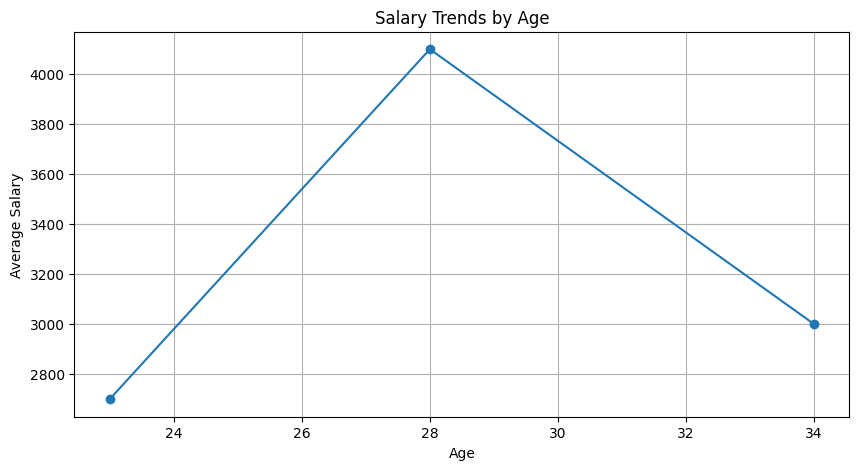

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

### 6. Homework
- **Tugas 1**: Gunakan Spark SQL untuk mencari total gaji dan jumlah karyawan per departemen. Buat visualisasi perbandingan antar departemen.
- **Tugas 2**: Temukan karyawan dengan gaji di atas rata-rata dalam setiap kelompok usia dan visualisasikan data ini dalam bentuk grafik batang atau pie chart.
- **Tugas 3**: Buat dataset yang lebih besar (misalnya, 100+ baris) dan lakukan analisis mendalam menggunakan SQL functions seperti `SUM()`, `AVG()`, `COUNT()`, serta `JOIN` antar tabel serta buat visualisasi yang menarik.


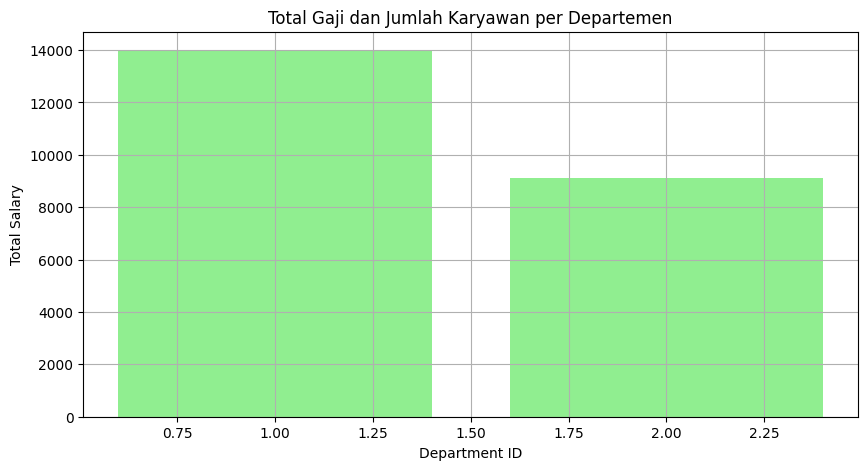

In [ ]:
# Gunakan Spark SQL untuk mencari total gaji dan jumlah karyawan per departemen. Buat visualisasi perbandingan antar departemen.
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
spark = SparkSession.builder.appName("Hands_On_Praktikum_9").getOrCreate()
data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('Faya', 25, 'F', 4000, 1),
    ('Kana', 40, 'F', 5000, 2),
    ('Joki', 45, 'M', 4300, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, columns)
df.createOrReplaceTempView('employees')

salary_karyawan = spark.sql('''
SELECT DeptId, SUM(Salary) as TotalSalary, COUNT(*) AS EmployeeCount
FROM employees
GROUP BY DeptId

''')

salary_karyawan_pd = salary_karyawan.toPandas()

plt.figure(figsize=(10, 5))
plt.bar(salary_karyawan_pd['DeptId'], salary_karyawan_pd['TotalSalary'], color='Lightgreen')
plt.xlabel('Department ID')
plt.ylabel('Total Salary')
plt.title('Total Gaji dan Jumlah Karyawan per Departemen')
plt.grid(True)
plt.show()

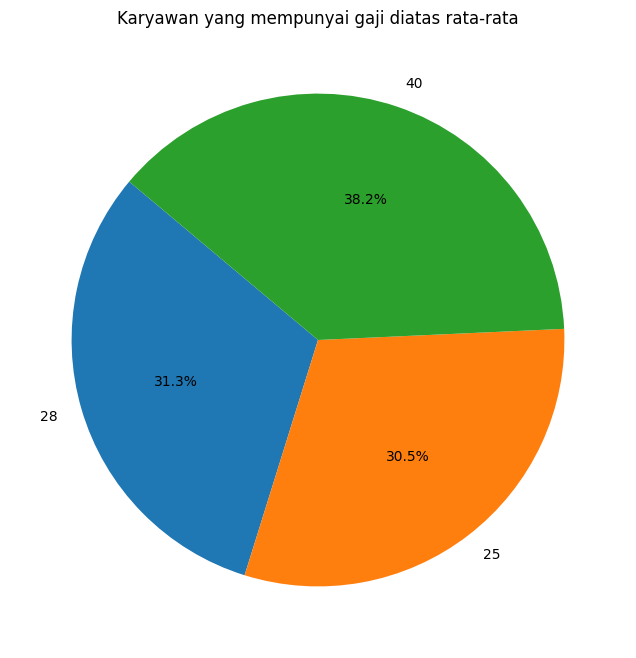

In [ ]:
# Temukan karyawan dengan gaji di atas rata-rata dalam setiap kelompok usia dan visualisasikan data ini dalam bentuk grafik batang atau pie chart
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.appName("Hands_On_Praktikum_9").getOrCreate()

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('Faya', 25, 'F', 4000, 1),
    ('Kana', 40, 'F', 5000, 2),
    ('Joki', 45, 'M', 4300, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']

df = spark.createDataFrame(data, columns)
df.createOrReplaceTempView('employees')

age_group_query = '''
SELECT
    CASE
        WHEN Age BETWEEN 20 AND 30 THEN '20-30'
        WHEN Age BETWEEN 31 AND 40 THEN '31-40'
        WHEN Age > 40 THEN '41+'
    END AS AgeGroup,
    AVG(Salary) AS AvgSalary
FROM employees
GROUP BY AgeGroup
'''

gaji_rata = spark.sql(above_avg_salary_query)
gaji_rata_usia = gaji_rata.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(gaji_rata_usia['Salary'], labels=gaji_rata_usia['Age'], autopct='%1.1f%%', startangle=140)
plt.title('Karyawan yang mempunyai gaji diatas rata-rata')
plt.show()

In [14]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('DataKaryawan').getOrCreate()
df_karyawan = spark.read.csv('DataKaryawan.csv', header = "True", inferSchema = "True")
df_karyawan.createOrReplaceTempView("DataKaryawan")

df_karyawan.show()

+-------------+----------+-------+
|         Nama|TahunKerja|   Gaji|
+-------------+----------+-------+
|        AHMAD|      2023|3900000|
|      ARFENDO|      2022|4600000|
|    LATIFUDIN|      2023|3700000|
|        HENDI|      2022|4300000|
|    M. FERYAN|      2022|3900000|
|        RENDI|      2024|5600000|
|       NUREKA|      2023|6000000|
|        INDRA|      2024|5400000|
|   MOCH IDWAL|      2023|6400000|
|  REYNO YUSUF|      2024|5700000|
|AHMAD MINANUL|      2023|6300000|
|       AFIZZA|      2024|5500000|
|          RIO|      2021|5600000|
|     MUKHOZIN|      2021|5700000|
|         ANDY|      2023|6100000|
|  STIFEN ZURO|      2022|6700000|
|       ROHMAT|      2023|6600000|
|    SAFRUDINI|      2024|8300000|
|AFRIZAL AHMAD|      2023|8100000|
+-------------+----------+-------+



In [ ]:
result_sum_avg_count= spark.sql('''
  SELECT
    SUM(Gaji) AS total_Gaji,
    AVG(Gaji) AS rata_rata_Gaji,
    COUNT(Gaji) AS jumlah_karyawan
    FROM DataKaryawan
''')
result_sum_avg_count.show()

+----------+-----------------+---------------+
|total_Gaji|   rata_rata_Gaji|jumlah_karyawan|
+----------+-----------------+---------------+
| 108400000|5705263.157894737|             19|
+----------+-----------------+---------------+



In [10]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Dataterbaru').getOrCreate()
dataterbaru= [
    (2023,"nguli","M"),
    (2021,"Programer","F"),
    (2022,"data analyst","M"),
    (2024,"engginer","L"),
]
df_dataterbaru = spark.createDataFrame(dataterbaru, ["TahunKerja","Pekerjaan","JenisKelamin"])
df_dataterbaru.createOrReplaceTempView("dataterbaru")
df_dataterbaru.show()


+----------+------------+------------+
|TahunKerja|   Pekerjaan|JenisKelamin|
+----------+------------+------------+
|      2023|       nguli|           M|
|      2021|   Programer|           F|
|      2022|data analyst|           M|
|      2024|    engginer|           L|
+----------+------------+------------+



+-------------+-------+----------+------------+
|         Nama|   Gaji|TahunKerja|   Pekerjaan|
+-------------+-------+----------+------------+
|AFRIZAL AHMAD|8100000|      2023|       nguli|
|       ROHMAT|6600000|      2023|       nguli|
|         ANDY|6100000|      2023|       nguli|
|AHMAD MINANUL|6300000|      2023|       nguli|
|   MOCH IDWAL|6400000|      2023|       nguli|
|       NUREKA|6000000|      2023|       nguli|
|    LATIFUDIN|3700000|      2023|       nguli|
|        AHMAD|3900000|      2023|       nguli|
|     MUKHOZIN|5700000|      2021|   Programer|
|          RIO|5600000|      2021|   Programer|
|  STIFEN ZURO|6700000|      2022|data analyst|
|    M. FERYAN|3900000|      2022|data analyst|
|        HENDI|4300000|      2022|data analyst|
|      ARFENDO|4600000|      2022|data analyst|
|    SAFRUDINI|8300000|      2024|    engginer|
|       AFIZZA|5500000|      2024|    engginer|
|  REYNO YUSUF|5700000|      2024|    engginer|
|        INDRA|5400000|      2024|    en

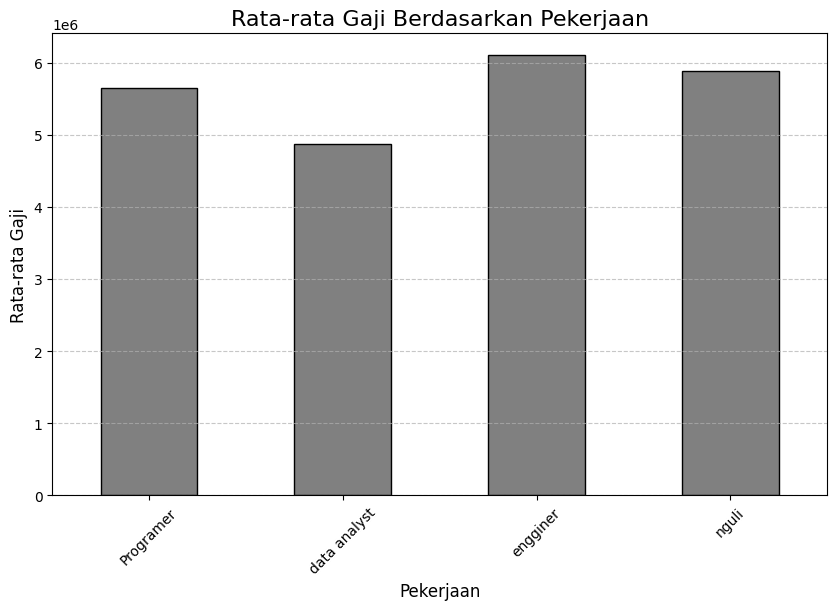

In [23]:
result = spark.sql('''
  SELECT k.Nama, k.Gaji, k.TahunKerja, d.Pekerjaan
  FROM DataKaryawan k
  JOIN dataterbaru d
  ON k.TahunKerja = d.TahunKerja
''')

result.show()

result_pandas = result.toPandas()
import matplotlib.pyplot as plt

# Group by pekerjaan dan ambil rata-rata gaji
avg_salary = result_pandas.groupby('Pekerjaan')['Gaji'].mean()

# Bar plot
plt.figure(figsize=(10, 6))
avg_salary.plot(kind='bar', color='grey', edgecolor='black')
plt.title('Rata-rata Gaji Berdasarkan Pekerjaan', fontsize=16)
plt.xlabel('Pekerjaan', fontsize=12)
plt.ylabel('Rata-rata Gaji', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [22]:
pip install pandas matplotlib